In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


In [2]:
BASE_DIR = Path.cwd().parent

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# 4. Model Training

In this notebook, we build our first models using **Logistic Regression** and **Random Forest**, two widely used algorithms for classification tasks.


## 4.1 Stratified Train/Test Split

To ensure robust evaluation, we split the final dataset (`df_final`) into training and test sets using an 80/20 ratio. Importantly, we apply **stratification** to preserve the class distribution across both subsets, which is crucial for imbalanced datasets.


In [3]:
df_final = pd.read_csv(
    BASE_DIR / "data/03_df_final.csv",
    encoding='utf-8',
    keep_default_na=False,  # <— don’t treat empty strings as NaN
    na_values=[]            # <— no additional “missing” tokens
)


In [4]:
from sklearn.model_selection import train_test_split

# Extract features and target
X = df_final.drop(columns=["pre_label", "Label"])  # nur Features
y = df_final['Label']

# Stratified split to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

# Combine back for inspection
train_df = X_train.assign(Label=y_train)
test_df  = X_test.assign(Label=y_test)

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)


Train shape: (400, 88)
Test shape:  (100, 88)


- **Stratified Sampling** ensures that both training and test sets reflect the original class proportions.
- `train_df` and `test_df` are now ready for model fitting and evaluation.
- Shapes printed above confirm the split and allow for quick sanity checks.


## 4.2 Prepare Numeric Feature Matrix for Modeling

Before fitting classifiers, we must ensure that **all input features are numeric**.  
This step filters out any remaining non-numeric columns (e.g., raw text or categorical labels), leaving only numerical and embedding-based features suitable for model training.


In [5]:
import numpy as np

# Select only numeric columns
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num  = X_test.select_dtypes(include=[np.number])

print("Numeric train shape:", X_train_num.shape)
print("Numeric test shape: ", X_test_num.shape)


Numeric train shape: (400, 53)
Numeric test shape:  (100, 53)


## 4.3 Train Baseline Classifiers

#### Why Start with Logistic Regression and Random Forest?

Before diving into deep learning or complex embeddings, we begin with two stalwarts of tabular modeling: **Logistic Regression** and **Random Forest**. These models aren’t just convenient; they offer complementary perspectives on the problem space.

Logistic Regression gives us a transparent, linear lens into the latent semantic structure extracted via SVD. Its coefficients are interpretable, its training fast, and its decision boundaries clean. It’s the kind of model that tells you what it’s thinking.

Random Forest, on the other hand, brings non-linear muscle. It thrives in mixed-type environments, capturing interactions between structured metadata and compressed text features without needing elaborate preprocessing. Its feature importance scores offer a different kind of interpretability; ne rooted in decision trees and ensemble wisdom.

Together, these models form a baseline duo: one linear, one tree-based. Their performance sets the floor for what we expect from more advanced pipelines. And later, they may even serve as ensemble partners to our embedding-based classifiers.

We train both using 5-fold cross-validation on the numeric feature matrix, measuring accuracy to establish a first benchmark.


In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=SEED)
}

# 5-fold CV on numeric features only
cv_results = {}
for name, clf in models.items():
    scores = cross_val_score(clf, X_train_num, y_train, cv=5, scoring="accuracy")
    cv_results[name] = (scores.mean(), scores.std())

# Display CV results
for name, (mean_acc, std_acc) in cv_results.items():
    print(f"{name}: {mean_acc:.3f} ± {std_acc:.3f}")


LogisticRegression: 0.920 ± 0.023
RandomForest: 0.910 ± 0.018


## 4.4 Hyperparameter Tuning

**Refining Logistic Regression for Maximum Accuracy**

Even simple models deserve careful attention. Here, we tune **Logistic Regression** using a focused grid search across regularization strengths and solver algorithms. The goal: to squeeze every bit of performance from our baseline by calibrating its bias–variance tradeoff.

We use **stratified 5-fold cross-validation** on the numeric feature matrix to ensure class balance during evaluation. This tuning step isn’t just procedural; it’s foundational. A well-optimized baseline gives us a trustworthy benchmark and a fair comparison point for more complex models down the line.


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning via GridSearchCV
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100], # Regularization strength
    "penalty": ["l2"], # Regularization type
    "solver": ["lbfgs", "saga"] # Optimization algorithm
}

lr = LogisticRegression(max_iter=5000, random_state=SEED)
grid = GridSearchCV(
    lr,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train_num, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.9199999999999999


**Optimal Logistic Regression Configuration**  
- **Best Hyperparameters**:  
  - Regularization strength `C = 0.01`  
  - Penalty type `l2`  
  - Solver `lbfgs`  

- **Cross-Validated Accuracy**: ~0.92  

With this tuning, our LR model strikes the right balance between bias and variance on the numeric feature set. We’ll now lock in these settings for the final hold-out evaluation.


### Hyperparameter Tuning for Random Forest

**Optimizing Random Forest for Imbalanced Classification**

Random Forests are powerful out of the box, but tuning them unlocks their full potential. Here, we perform a grid search across key hyperparameters:
- tree depth,
- number of estimators, 
- and leaf size.
We also activate `class_weight="balanced"` to ensure the model treats minority classes with equal attention.

Unlike Logistic Regression, our scoring metric here is **F1-score**, which better reflects performance under class imbalance. The tuning is done via **5-fold cross-validation** on the numeric feature matrix, ensuring robustness across splits.


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "class_weight": ["balanced"]
}

rf = RandomForestClassifier(random_state=SEED)
grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=0
)

grid_rf.fit(X_train_num, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best CV F1-score:", grid_rf.best_score_)


Best RF params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 100}
Best CV F1-score: 0.9045981045981046


* This Random Forest setup with deep trees (max_depth=None), balanced class weighting, and a minimum of 10 samples per leaf, strikes a strong balance between complexity and generalization, yielding a solid F1-score of 0.905 despite class imbalance, which suggests the model captures meaningful structure in both text and metadata without overfitting.

## 4.5 Model Evaluation

### Evaluate Tuned Logistic Regression and Random Forest

We now fit both tuned classifiers on the full training split and evaluate them on the hold-out test set. This mirrors the methodology used earlier in our exploratory case study and allows us to quantify generalization performance.

- **Random Forest** is configured using the optimal parameters obtained through grid search (`class_weight='balanced'`, `max_depth=None`, `min_samples_leaf=10`, `n_estimators=100`), ensuring effective handling of class imbalance and deep feature interactions.
- **Logistic Regression** is locked with its tuned hyperparameters (`C=0.01`, `penalty='l2'`, `solver='lbfgs'`), offering a regularized, interpretable linear decision surface over the latent semantic space.

For both models, we report core classification metrics: **Accuracy**, **Precision**, **Recall**, and **F1-score**, and present their confusion matrices to inspect prediction fidelity across classes.


* To preserve the finalized models and ensure reproducibility, we serialize both the tuned Random Forest and Logistic Regression classifiers using joblib. These versions reflect the optimal parameter settings identified during hyperparameter tuning and are trained on the entire training data. Additionally, we store the list of selected numerical feature columns to maintain consistency in future inference tasks. This safeguards our pipeline and enables seamless deployment or further analysis without retraining from scratch.

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Retrieve best models from GridSearchCV
best_rf = grid_rf.best_estimator_
best_lr = grid.best_estimator_

# Fit models
best_rf.fit(X_train_num, y_train)
best_lr.fit(X_train_num, y_train)

# Save the final models
joblib.dump(best_rf, BASE_DIR / "checkpoints/random_forest_final_model.pkl")
joblib.dump(best_lr, BASE_DIR / "checkpoints/logreg_final_model.pkl")
# Save the final feature columns
X_train_num = X_train.select_dtypes(include=[np.number])
joblib.dump(X_train_num.columns.tolist(), BASE_DIR / "checkpoints/final_features_columns.pkl")


# Make predictions
y_pred_rf = best_rf.predict(X_test_num)
y_pred_lr = best_lr.predict(X_test_num)

def compute_metrics(y_true, y_pred, model_name):
    """Compute and return evaluation metrics for a given model."""
    return {
        "Model": model_name,
        "Accuracy %": round(accuracy_score(y_true, y_pred) * 100, 2),
        "Precision %": round(precision_score(y_true, y_pred) * 100, 2),
        "Recall %": round(recall_score(y_true, y_pred) * 100, 2),
        "F1-score %": round(f1_score(y_true, y_pred) * 100, 2),
    }

# Compute metrics for both models
metrics = [
    compute_metrics(y_test, y_pred_rf, "Random Forest"),
    compute_metrics(y_test, y_pred_lr, "Logistic Regression"),
]

print(pd.DataFrame(metrics).to_markdown(index=False))

| Model               |   Accuracy % |   Precision % |   Recall % |   F1-score % |
|:--------------------|-------------:|--------------:|-----------:|-------------:|
| Random Forest       |           93 |         97.78 |         88 |        92.63 |
| Logistic Regression |           94 |        100    |         88 |        93.62 |


### Confusion Matrices

To analyze classification performance beyond aggregate metrics, we visualize **confusion matrices** for both the tuned Random Forest and Logistic Regression models. This offers deeper insight into how well each model distinguishes between the positive and negative classes on the unseen test data.

The matrices display:

| tn | fp |

| fn | tp |

If you're new to confusion matrices and curious about what these terms mean, you may find [this tutorial](https://medium.com/data-science/taking-the-confusion-out-of-confusion-matrices-c1ce054b3d3e) helpful.

We plot them side by side using seaborn heatmaps for quick visual comparison:


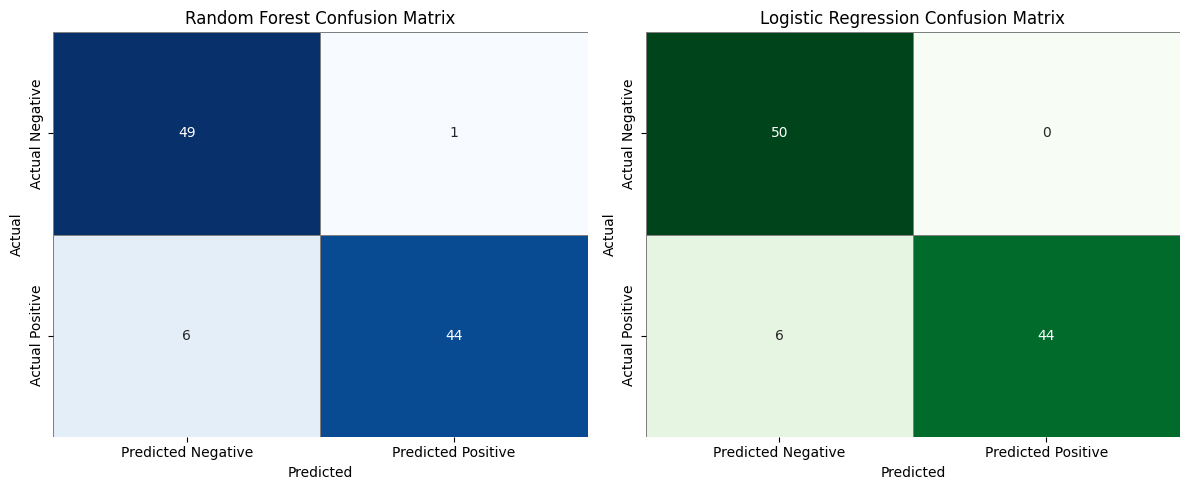

In [10]:
from sklearn.metrics import confusion_matrix

# Plot confusion matrices side by side
models = [("Random Forest", y_pred_rf, "Blues"), ("Logistic Regression", y_pred_lr, "Greens")]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (title, y_pred, cmap) in zip(axes, models):
    cm = confusion_matrix(y_test, y_pred)  # ✅ use y_pred from loop
    df_cm = pd.DataFrame(cm,
        index=["Actual Negative", "Actual Positive"],
        columns=["Predicted Negative", "Predicted Positive"]
    )
    sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap, cbar=False,
                ax=ax, linewidths=0.5, linecolor='gray')
    ax.set_title(f"{title} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.savefig(BASE_DIR / "plots/confusion_matrices_side_by_side.png", dpi=150)
plt.show()


* Logistic Regression edges out Random Forest with perfect precision, zero false positives, making it the safer bet for regulated Life-Science recommendations. Both models retrieve relevant apps equally well (88% recall), but Random Forest’s slight dip in precision suggests a looser filter. The trade-off is clear: interpretability and reliability with Logistic Regression versus flexibility and pattern depth with Random Forest. In high-stakes domains, precision wins.

## 4.6. Feature Importance Analysis

### Visualizing Feature Importances with Random Forest

To better understand which features most influenced the Random Forest model, we calculate and visualize their importances using the **Mean Decrease in Impurity (MDI)** method. This technique measures the total reduction of the criterion (e.g., Gini impurity) brought by each feature across all trees in the ensemble.

We use [`feature_importances_`](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)  from the fitted Random Forest to compute the scores and plot a bar chart that includes the standard deviation across the trees, offering insight into feature stability.



/tmp/ipykernel_74708/3984000849.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_importances = forest_importances[sorted_idx]
/tmp/ipykernel_74708/3984000849.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


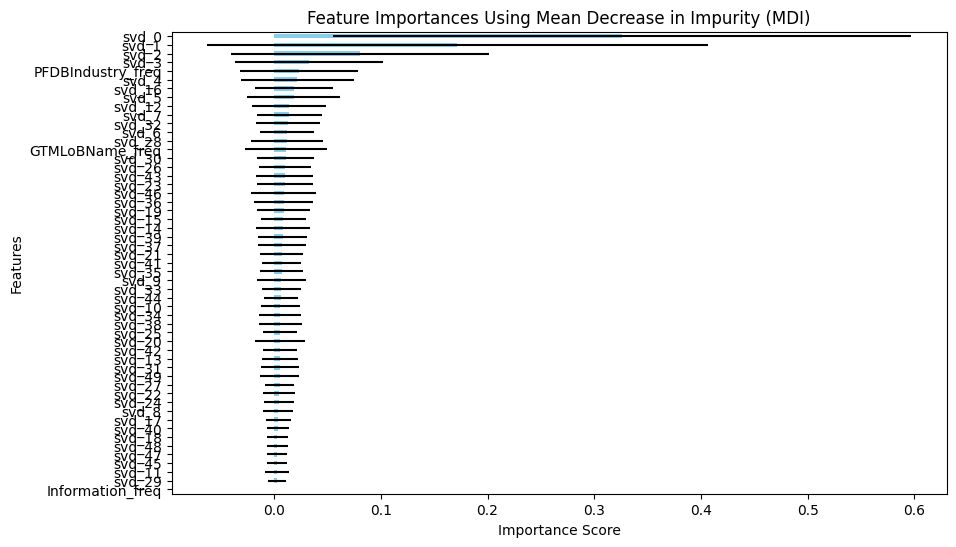

In [11]:
# Extract importances and compute standard deviation
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)

# Use actual feature names
feature_names = X_train_num.columns.tolist()
forest_importances = pd.Series(importances, index=feature_names)

# Sort features by importance for better readability
sorted_idx = forest_importances.argsort()
sorted_importances = forest_importances[sorted_idx]
sorted_std = std[sorted_idx]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.barh(xerr=sorted_std, ax=ax, color='skyblue')
ax.set_title("Feature Importances Using Mean Decrease in Impurity (MDI)")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")
fig.savefig(BASE_DIR / "plots/feature_importances.png", dpi=300)
fig.show()

###  Top-5 Permutation Importances

To pinpoint which features truly matter, we shuffled each input and measured the resulting accuracy drop. The top-5 features for **Logistic Regression** reflect direct, stable signals—ideal for interpretable decision-making. In contrast, **Random Forest** surfaces features that drive complex, non-linear splits across trees.

The divergence in rankings reveals how each model "sees" the data: Logistic Regression favors clarity, Random Forest rewards interaction. Together, they offer complementary lenses on what drives relevance.


In [12]:
from sklearn.inspection import permutation_importance

# compute importances
lr_res = permutation_importance(best_lr, X_test_num, y_test,
                                n_repeats=15, random_state=SEED,
                                scoring="accuracy", n_jobs=-1)
rf_res = permutation_importance(best_rf, X_test_num, y_test,
                                n_repeats=15, random_state=SEED,
                                scoring="accuracy", n_jobs=-1)

# build Series and DataFrames
lr_imp = pd.Series(lr_res.importances_mean, index=X_test_num.columns)
rf_imp = pd.Series(rf_res.importances_mean, index=X_test_num.columns)

lr_df = lr_imp.nlargest(5).reset_index()
lr_df.columns = ['feature', 'importance']
rf_df = rf_imp.nlargest(5).reset_index()
rf_df.columns = ['feature', 'importance']

# display
print("**Top-5 Permutation Importances — Logistic Regression**")
print(lr_df.to_markdown(index=False))
print("\n**Top-5 Permutation Importances — Random Forest**")
print(rf_df.to_markdown(index=False))


**Top-5 Permutation Importances — Logistic Regression**
| feature           |   importance |
|:------------------|-------------:|
| svd_0             |   0.371333   |
| GTMLoBName_freq   |   0.0373333  |
| PFDBIndustry_freq |   0.0326667  |
| svd_5             |   0.0173333  |
| svd_1             |   0.00266667 |

**Top-5 Permutation Importances — Random Forest**
| feature          |   importance |
|:-----------------|-------------:|
| svd_0            |   0.268667   |
| svd_32           |   0.00333333 |
| GTMLoBName_freq  |   0          |
| Information_freq |   0          |
| svd_3            |   0          |


* Logistic Regression relies heavily on **svd_0**, but also values categorical frequency features, suggesting a balanced use of semantic and structured signals. Random Forest, meanwhile, is dominated by **svd_0** alone, with minimal impact from other inputs, hinting at a more selective pattern focus.

This raises a key question: what does **svd_0** actually represent?  
Let’s decode it next by mapping SVD components back to their top contributing terms.


### SVD Feature → Top-5 Terms Mapping

To demystify the semantic meaning behind top SVD components, we traced each back to its most influential TF-IDF terms. This reveals what latent topics the models are actually leveraging, whether it's domain-specific jargon, recurring themes, or regulatory keywords.

Understanding these mappings helps bridge the gap between abstract embeddings and actionable insights, grounding model behavior in real language.


Before decoding the top SVD components, we first retrieve the term-to-component mapping from our previous notebook:

In [13]:
svd_feature_mapping = pd.read_csv(BASE_DIR / "data/03_svd_feature_mapping.csv", index_col=0)

In [14]:
mapping = []
for feat in pd.concat([lr_df['feature'], rf_df['feature']]).unique():
    if feat.startswith("svd_"):
        idx = int(feat.split("_")[1])
        # svd_feature_mapping is a DataFrame: rows = component, columns = features
        terms = svd_feature_mapping.loc[f"svd_{idx}"] \
                .nlargest(5).index.tolist()
        mapping.append((feat, ", ".join(terms)))
    else:
        mapping.append((feat, feat))

map_df = pd.DataFrame(mapping, columns=['feature', 'mapped_terms']) \
          .drop_duplicates()

print("**SVD Feature → Top-5 Terms Mapping**")
print(map_df.to_markdown(index=False))


**SVD Feature → Top-5 Terms Mapping**
| feature           | mapped_terms                                                                       |
|:------------------|:-----------------------------------------------------------------------------------|
| svd_0             | sap, sap fiori, fiori, cloud, experience                                           |
| GTMLoBName_freq   | GTMLoBName_freq                                                                    |
| PFDBIndustry_freq | PFDBIndustry_freq                                                                  |
| svd_5             | production, manufacturing, discrete, discrete manufacturing, production supervisor |
| svd_1             | accounts, payable, accounts payable, accountant, receivable                        |
| svd_32            | sales, warehouse, asset, project, depreciation                                     |
| Information_freq  | Information_freq                                                                   |

**SVD Component Interpretation**

The mapping reveals that **svd_0**, the most influential feature across both models, captures terms like *sap*, *fiori*, and *cloud*,strong indicators of enterprise software relevance. Meanwhile, **svd_5** leans into *manufacturing* and *production*, pointing to industrial use cases.

This semantic unpacking shows that the models aren’t just learning patterns; they’re anchoring decisions in domain-specific language. It’s a peek into the linguistic DNA driving relevance.


### Combined LR vs RF Importances

To highlight how feature relevance differs between models, we visualize the top-5 permutation importances side by side. This comparison reveals where Logistic Regression and Random Forest align, and where their priorities diverge.


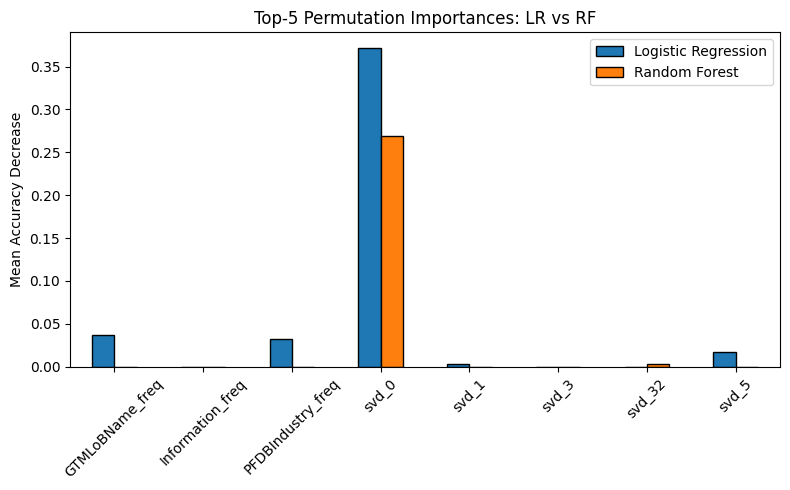

In [15]:
combined = pd.DataFrame({
    'Logistic Regression': lr_imp.nlargest(5),
    'Random Forest':      rf_imp.nlargest(5)
})

ax = combined.plot.bar(figsize=(8,5), rot=45, edgecolor='k')
ax.set_ylabel("Mean Accuracy Decrease")
ax.set_title("Top-5 Permutation Importances: LR vs RF")
plt.tight_layout()
plt.savefig(BASE_DIR / "plots/top5_perm_importance_lr_rf.png", dpi=300)
plt.show()


### Key Takeaways: SVD & Permutation Analysis

Both models converge on **svd_0** as the dominant signal, pointing to a core Life-Science topic embedded in the TF-IDF space. But their divergence is telling: Logistic Regression leans on categorical frequency features, while Random Forest taps into deeper latent patterns like **svd_32**, hinting at niche domains such as oil and gas.

The takeaway? Semantic embeddings and structured metadata aren’t rivals; they’re allies. Together, they build a more nuanced and powerful relevance engine.


## 4.7 Embedding Visualisations  
### UMAP + HDBSCAN Scatter  

To truly understand how relevance emerges from text, we need to see the landscape itself. By projecting high-dimensional TF–IDF vectors into two dimensions using **UMAP**, we reveal the hidden geometry of app descriptions. Then, with **HDBSCAN**, we uncover dense semantic neighborhoods; natural clusters that may or may not align with our manual labels.

- **Objective:** Explore the organic structure of app descriptions in 2D space and assess how well our ground-truth labels reflect these semantic groupings.  
- **UMAP Projection:** Preserves both global and local relationships in the data, mapping each app into a position on the “UMAP-1” and “UMAP-2” axes, like plotting stars in a galaxy of meaning.

This visualisation sets the stage for the next step: examining how decision boundaries interact with these clusters. Are our models drawing lines through coherent regions, or slicing across semantic seams? Let’s find out.


/home/khalaji/Coding/text-classification-life-sciences/.venv_lf/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


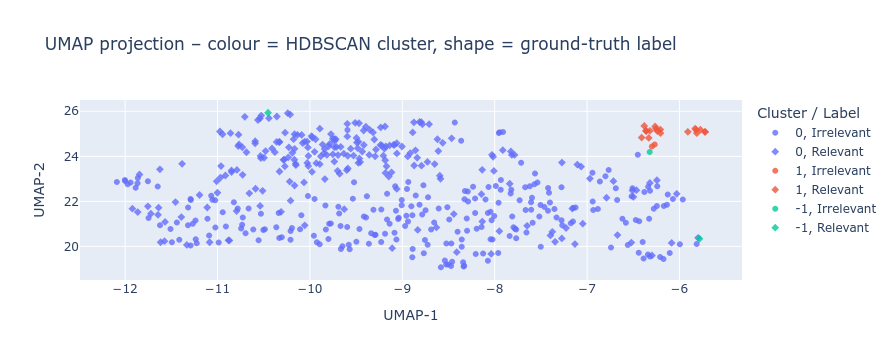

In [16]:
import umap.umap_ as umap
from sklearn.cluster import HDBSCAN
import plotly.express as px

# Load the TF-IDF vectorized data from last notebook
X_tfidf = joblib.load(BASE_DIR / "checkpoints/X_tfidf_vectorized.pkl")

# Load the transformed DataFrame
df_transformed = pd.read_csv(BASE_DIR / "data/03_df_transformed.csv")

# UMAP coordinates
reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, metric="hellinger", random_state=SEED)
coords = reducer.fit_transform(X_tfidf)

# Density-based clusters
hdb = HDBSCAN(min_cluster_size=15, min_samples=10)
hdb_labels = hdb.fit_predict(coords)

# Hover text
plot_df = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "cluster": hdb_labels.astype(str),
    "LabelTxt": y.reset_index(drop=True).map({1: "Relevant", 0: "Irrelevant"}),
    "App": df_transformed.loc[y.index, "AppName"],          # short title
    "ID":  df_transformed.loc[y.index, "fioriId"],          # SAP ID
    "Snippet": df_final.loc[y.index, "all_text_label"].str[:80]
})

fig = px.scatter(
    plot_df,
    x="x", y="y",
    color="cluster",
    symbol="LabelTxt",
    hover_name="App",
    hover_data={"ID": True, "Snippet": True, "x": False, "y": False},
    opacity=0.8,
    title="UMAP projection – colour = HDBSCAN cluster, shape = ground-truth label"
)
fig.update_layout(xaxis_title="UMAP-1", yaxis_title="UMAP-2", legend_title="Cluster / Label")
fig.write_html(BASE_DIR / "reports/umap_hdbscan_clusters.html", include_plotlyjs="cdn")
fig.show()

**Cluster Insights: When Semantics Speak Louder Than Labels**

The HDBSCAN clustering reveals a compelling narrative beneath the surface:

- **Cluster 1 (orange/red)** stands out as a textbook case of domain isolation. Its near-total irrelevance and thematic cohesion, centered on “Oil & Gas” jargon, suggest that specialized language forms a distinct semantic island, easily flagged by both models and humans.
  
- **Cluster 0 (blue)**, however, is where the story gets messy. This mixed zone blurs the line between relevance and irrelevance, exposing the limits of surface-level features. It’s a semantic grey area. where apps share vocabulary but diverge in purpose.

- **Noise (−1, green)** is the semantic wilderness. These outliers, all irrelevant, underscore HDBSCAN’s precision: if it can’t find a home for them, they likely don’t belong anywhere meaningful.

These clusters hint at a deeper truth: relevance isn’t just about words, it’s about context, intent, and domain nuance. And that’s exactly where decision boundaries must tread carefully.


### Cluster Word-Clouds: Language as a Lens

To decode the semantic DNA of each HDBSCAN cluster, we generate word clouds that highlight dominant terms:

- **Cluster 1** is saturated with domain-specific language—“Oil”, “Gas”, “Upstream”—confirming its identity as a tightly knit, irrelevant group.
- **Cluster 0** reveals a more ambiguous vocabulary: generic verbs like “display” and “transaction” appear across both classes, reflecting its mixed composition.

By filtering out common Fiori terms and stopwords, these clouds expose the linguistic fingerprints that shape cluster boundaries—offering a visual intuition for how relevance emerges from text.


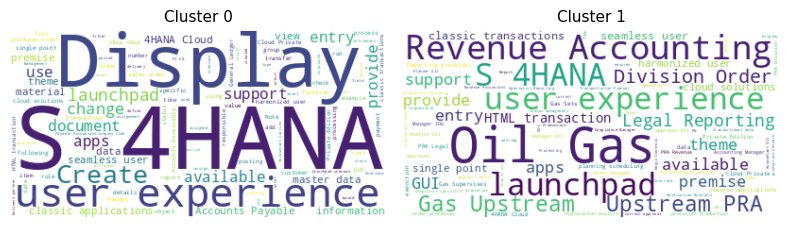

In [17]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


custom_words = {"sap", "fiori", "app", "application"}
stop_words  = set(ENGLISH_STOP_WORDS).union(custom_words)

valid = [c for c in np.unique(hdb_labels) if c != -1]
fig_wc, axes = plt.subplots(1, len(valid), 
                            figsize=(4*len(valid), 3), tight_layout=True)

for ax, cid in zip(axes, valid):
    text_blob = " ".join(df_final.loc[hdb_labels == cid, "all_text_label"])
    wc = WordCloud(
        background_color="white",
        random_state=SEED,
        stopwords=stop_words
    ).generate(text_blob)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Cluster {cid}", fontsize=11)
    ax.axis("off")

fig_wc.savefig(BASE_DIR / "plots/cluster_wordclouds.png", dpi=150, bbox_inches="tight")
plt.show()



- Cluster 0 speaks the language of everyday SAP apps, generic verbs and UI terms shared across use cases.  
- Cluster 1, on the other hand, is pure “Oil & Gas”, a tightly focused, irrelevant niche.

These clouds confirm: HDBSCAN doesn’t just group data, it surfaces meaning.

### Cluster Purity Table  

To quantify how well HDBSCAN separates relevance, we calculate the percentage of **Relevant** vs **Irrelevant** apps in each cluster.

This table reveals the semantic clarity of each group, whether it's a clean domain-specific cluster or a noisy mix. It’s a simple yet powerful metric to validate our unsupervised structure against ground-truth labels.


In [18]:
# Compute cluster purity: share of Relevant vs Irrelevant in each cluster
label_pct = (
    pd.crosstab(hdb_labels, y, normalize="index")
      .mul(100)
      .round(1)
      .rename(columns={0: "Irrelevant %", 1: "Relevant %"})
)
label_pct.index.name = "Cluster"

# save & display
label_pct.to_csv(BASE_DIR / "plots/cluster_label_percentages.csv")
display(
    label_pct.style.format("{:.1f}")
              .set_caption("Share of ground-truth labels per cluster (%)")
)


Label,Irrelevant %,Relevant %
Cluster,,
-1,33.3,66.7
0,51.8,48.2
1,10.0,90.0


### Purity Check: Numbers That Back the Narrative

This table reinforces our earlier insights:

- **Cluster 1** is highly pure, 90% Relevant—confirming it as a focused Life-Science group.
- **Cluster 0** remains ambiguous, with a near-even split, echoing its mixed vocabulary.
- **Noise (−1)** surprisingly includes some Relevant apps, suggesting that even outliers may carry meaningful signals.

Together, these stats validate the semantic structure revealed by UMAP and HDBSCAN, and hint at where our models must tread carefully.


With semantic structure and cluster purity mapped out, we now shift gears from exploration to prediction.

In the [next notebook](https://github.com/alikhalajii/text-classification-life-sciences/blob/master/notebooks/02-exploratory-data-analysis-data-labeling.ipynb), we’ll dive deeper into classification using powerful deep learning models like **Sentence Transformers**. These embeddings promise richer context, better generalization, and sharper decision boundaries.

Let’s see how far semantics can take us.